# SSD: Visualization

In [1]:
import random
import numpy as np

from image_generator import ImageGenerator
from models import SSD300
from utils.prior_box_creator import PriorBoxCreator
from utils.prior_box_manager import PriorBoxManager
from utils.box_visualizer import BoxVisualizer
from utils.XML_parser import XMLParser
from data_loader import  DataLoader
from utils.utils import split_data
from utils.utils import load_image
from utils.utils import plot_images
from utils.utils import get_class_names
from utils.utils import get_arg_to_class
dataset_name = 'COCO'
root_prefix = '../datasets/COCO/'
ground_data_prefix = root_prefix + ''
image_prefix = root_prefix + 'images/train2014/'

Using TensorFlow backend.


## Class specification

In [2]:
class_names = get_class_names(dataset_name)
arg_to_class = get_arg_to_class(class_names)
num_classes = len(class_names)
ground_truth_manager = DataLoader(dataset_name)
ground_truth_data = ground_truth_manager.get_data()
print(len(ground_truth_data), ' images fround with classes', class_names)

loading annotations into memory...
Done (t=10.60s)
creating index...
index created!
82081  images fround with classes ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Prior boxes creator

In [3]:
model = SSD300()
image_shape = model.input_shape[1:3]
box_creator = PriorBoxCreator(model)
prior_boxes = box_creator.create_boxes()
print('Number of prior boxes:', len(prior_boxes))

Number of prior boxes: 7308


## Prior boxes 

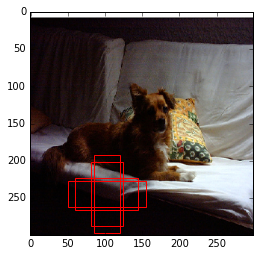

In [4]:
box_visualizer = BoxVisualizer(image_prefix, image_shape, arg_to_class)
box_coordinates = prior_boxes[6080:6084, :]
box_visualizer.draw_normalized_box(box_coordinates)

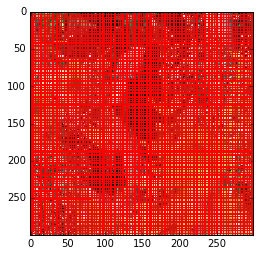

In [5]:
box_visualizer = BoxVisualizer(image_prefix, image_shape, arg_to_class)
box_coordinates = prior_boxes[4400:6400, :]
box_visualizer.draw_normalized_box(box_coordinates)

## Ground truths

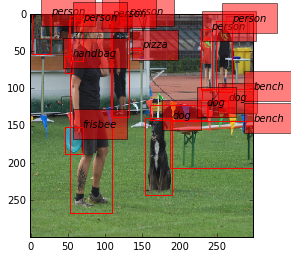

In [8]:
# drawing ground truths
selected_key =  random.choice(list(ground_truth_data.keys()))
selected_data = ground_truth_data[selected_key]
selected_box_coordinates = selected_data[:, 0:4]
box_visualizer.draw_normalized_box(selected_data, selected_key)

## Assigned default boxes

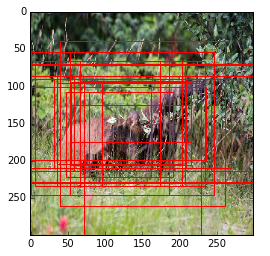

In [9]:
selected_key =  random.choice(list(ground_truth_data.keys()))
selected_data = ground_truth_data[selected_key]
prior_box_manager = PriorBoxManager(prior_boxes, num_classes=num_classes)
assigned_encoded_boxes = prior_box_manager.assign_boxes(selected_data)
assigned_prior_boxes = prior_box_manager.assigned_prior_boxes
assigned_prior_boxes = np.concatenate(assigned_prior_boxes, 0)
#assigned_prior_boxes
box_visualizer.draw_normalized_box(assigned_prior_boxes, selected_key)

## Assigned encoded boxes

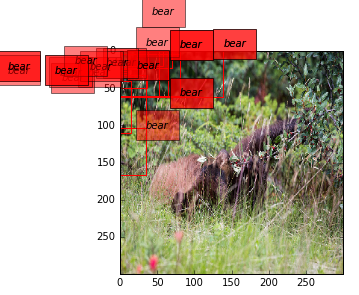

In [10]:
prior_box_manager = PriorBoxManager(prior_boxes, num_classes=num_classes)
assigned_encoded_boxes = prior_box_manager.assign_boxes(selected_data)
positive_mask = assigned_encoded_boxes[:, 4] != 1
encoded_positive_boxes = assigned_encoded_boxes[positive_mask]
box_visualizer.draw_normalized_box(encoded_positive_boxes, selected_key)

## Assigned Decoded boxes

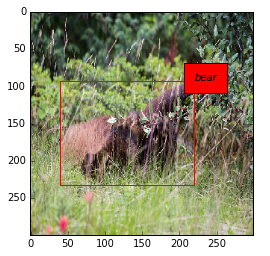

In [11]:
assigned_decoded_boxes = prior_box_manager.decode_boxes(assigned_encoded_boxes)
decoded_positive_boxes = assigned_decoded_boxes[positive_mask]
box_visualizer.draw_normalized_box(decoded_positive_boxes, selected_key)

## Data augmentation

COCO_train2014_000000563447.jpg
(12, 85)


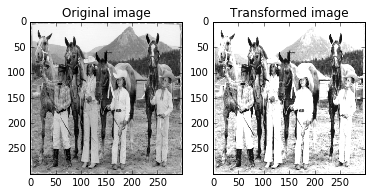

In [16]:
# drawing generator output
train_keys, validation_keys = split_data(ground_truth_data, training_ratio=.8)
image_generator = ImageGenerator(ground_truth_data,
                                 prior_box_manager,
                                 1, image_shape,
                                 train_keys, validation_keys,
                                 image_prefix,
                                 vertical_flip_probability=0,
                                 horizontal_flip_probability=.5)

generated_data = next(image_generator.flow(mode='demo'))
generated_input = generated_data[0]['input_1']
generated_output = generated_data[1]['predictions']
generated_image = np.squeeze(generated_input[0]).astype('uint8')
validation_image_name = image_prefix + validation_keys[0]
#original_image = read_image(validation_image_name)
#original_image = resize_image(original_image, image_shape)
original_image = load_image(validation_image_name, False, image_shape)
plot_images(original_image, generated_image)

## Modified ground-truth

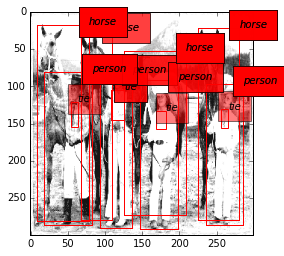

In [17]:
# finally draw the assigned boxes given by the generator
generated_encoded_boxes = np.squeeze(generated_output)
generated_boxes = prior_box_manager.decode_boxes(generated_encoded_boxes)
positive_mask = generated_boxes[:, 4] != 1
generated_positive_boxes = generated_boxes[positive_mask]
box_visualizer.draw_normalized_box(generated_positive_boxes, image_array=generated_image)